In [1]:
import numpy as np
import pandas as pd
import gc
import os
import sys
import yaml
import re
import random
import math
import matplotlib.pyplot as plt
import warnings
import pickle
from tqdm.notebook import tqdm
from typing import *
from pathlib import Path
from dataclasses import dataclass, field, asdict
from shutil import copyfile
from cuml.neighbors import NearestNeighbors
warnings.simplefilter('ignore')

In [2]:
@dataclass
class Config:
    outdir: str = "../results/efficientnet-tpu"
    device: str = "cuda:1"
    device_id: int = 1

    en_type: str = 'B3'
    datadir: str = '../data/tfrecord-skf'
    image_dir: str = '../data/shopee-product-matching/train_images'
    seed: int = 42
    n_splits: int = 3
    tf_expt: int = -1
    image_size: List[int] = field(default_factory=lambda: [512, 512])
    
    # Training config
    batch_size: int = 20
    epochs: int = 100
    patience: int = 5
    lr: float = 0.00001

    def update(self, param_dict: Dict) -> "Config":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self
    
    def to_yaml(self, filepath: str, width: int = 120):
        with open(filepath, 'w') as f:
            yaml.dump(asdict(self), f, width=width)

In [3]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [4]:
config = Config()
os.environ["CUDA_VISIBLE_DEVICES"] = str(config.device_id)

base_dir = Path().resolve()
sys.path.append(os.path.abspath(base_dir / '../'))

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
import efficientnet.tfkeras as efn

# physical_devices = tf.config.list_physical_devices('GPU')
# if len(physical_devices) > 0:
#     for device in physical_devices:
#         tf.config.experimental.set_memory_growth(device, True)
#         print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
# else:
#     print("Not enough GPU hardware devices available")

from src.tokenization import *
from src.preprocess import *
from src.image import *
from src.model import *

In [5]:
# Data augmentation function
def data_augment(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return image

In [6]:
# Function to get our f1 score
def f1_score(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    intersection = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    len_y_pred = y_pred.apply(lambda x: len(x)).values
    len_y_true = y_true.apply(lambda x: len(x)).values
    f1 = 2 * intersection / (len_y_pred + len_y_true)
    return f1

In [7]:
# Function to read our test image and return image
def read_image(image, image_size):
    image = tf.io.read_file(image)
    image = decode_image(image, image_size)
    return image


# Function to get our dataset that read images
def get_dataset(image, config, tta):
    tta = 1 if tta <= 1 else tta
    datasets = list()
    for _ in range(tta):
        dataset = tf.data.Dataset.from_tensor_slices(image)
        dataset = dataset.map(lambda x: read_image(x, config.image_size), num_parallel_calls = config.tf_expt)
        dataset = dataset.map(data_augment, num_parallel_calls = config.tf_expt)
        dataset = dataset.batch(config.batch_size)
        dataset = dataset.prefetch(config.tf_expt)
        datasets += [dataset]
    return datasets

In [8]:
train = pd.read_csv(base_dir / config.datadir / 'train_folds.csv')
n_classes = train['label_group'].nunique()
n_classes

11014

In [9]:
def get_embeddings(df: pd.DataFrame, fold: int, epoch: int, tta: int = -1):
    image_paths = [str(base_dir / config.image_dir / filename) for filename in df['image']]
    
    model = build_efficientnet_model(
        n_classes=n_classes,
        image_size=config.image_size,
        lr=config.lr,
        en_type=config.en_type,
        train=False
    )
    model.load_weights(str(base_dir / config.outdir / f'EfficientNetB3_seed{config.seed}_fold{fold}' / f"epoch{format(epoch, '02')}.h5"))
    model = tf.keras.models.Model(inputs=model.input[0:3], outputs=model.layers[-4].output)
    
    chunk = 500
    iterator = np.arange(np.ceil(len(df) / chunk))

    embeds = []
    for j in tqdm(iterator):
        a = int(j * chunk)
        b = int((j + 1) * chunk)

        image_datasets = get_dataset(image_paths[a:b], config, tta=tta)
        embeddings = np.hstack([model.predict(image_dataset) for image_dataset in image_datasets]).reshape(len(image_paths[a:b]), tta, -1)
        embeds.append(embeddings)
    
    del model
    gc.collect()
    tf.keras.backend.clear_session()
    return np.concatenate(embeds)

In [10]:
def get_valid_df(fold: int):
    valid_folds = [i for i in range(train.fold.unique().shape[0]) if (i % config.n_splits) == fold]
    print(f'folds : {valid_folds}')
    
    valid_df = train.query(f'fold in {valid_folds}').copy()
    return valid_df

In [11]:
# VALID = False
# EPOCH = 20
# TTA = 10

# embeddings_list = list()
# for i in range(config.n_splits):
#     if VALID:
#         embeddings = get_embeddings(df=train, fold=i, epoch=EPOCH, tta=TTA)
#         pickle.dump(
#             embeddings,
#             open(str(base_dir / config.outdir / f'EfficientNetB3_seed{config.seed}_fold{i}' / f'embeddings_epoch{EPOCH}_tta{TTA}.pkl'), 'wb')
#         )
#         embeddings_list += [embeddings]
#     else:
#         embeddings = pickle.load(open(str(base_dir / config.outdir / f'EfficientNetB3_seed{config.seed}_fold{i}' / f'embeddings_epoch{EPOCH}_tta{TTA}.pkl'), 'rb'))
#         embeddings_list += [embeddings]

In [12]:
EPOCH = 20
TTA = 10

embeddings_list, embeddings_tta_list = list(), list()
for i in range(config.n_splits):
    embeddings_list += [pickle.load(open(str(base_dir / config.outdir / f'EfficientNetB3_seed{config.seed}_fold{i}' / f'embeddings_epoch{EPOCH}.pkl'), 'rb'))]
    embeddings_tta_list += [pickle.load(open(str(base_dir / config.outdir / f'EfficientNetB3_seed{config.seed}_fold{i}' / f'embeddings_epoch{EPOCH}_tta{TTA}.pkl'), 'rb'))]

In [15]:
embeddings_tta_list[0]

dtype('float32')

In [38]:
KNN = 5
TTA = 2

fold = 0
embeddings = embeddings_list[fold]
embeddings_tta = embeddings_tta_list[fold]

knn_model = NearestNeighbors(n_neighbors=50)
knn_model.fit(embeddings)

valid_df = get_valid_df(fold=fold)
valid_embeddings_tta = embeddings_tta[valid_df.index, :, :]

distances_list, indices_list = list(), list()
for i in tqdm(range(TTA)):
    distances_i, indices_i = knn_model.kneighbors(valid_embeddings_tta[:, i, :])
    distances_list += [distances_i]
    indices_list += [indices_i]


distances = np.hstack(distances_list)
indices = np.hstack(indices_list)

distances = np.sort(distances)
indices = np.array([indices[i][distances[i].argsort()] for i in tqdm(range(distances.shape[0]))])

folds : [0, 3, 6, 9, 12]


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/11417 [00:00<?, ?it/s]

In [49]:
mer_distances, mer_indices = list(), list()

for i in tqdm(range(distances.shape[0])):
    tmp = pd.DataFrame({'dis': distances[i, :], 'idx': indices[i, :]}).groupby('idx').mean().reset_index().sort_values('dis')
    mer_distances += [tmp.dis.values]
    mer_indices += [tmp['idx'].values]

  0%|          | 0/11417 [00:00<?, ?it/s]

In [56]:
# grid search
thresholds = list(np.arange(2, 6, 0.2))

scores = []
for threshold in thresholds:
    predictions = []
    for k in range(valid_embeddings_tta.shape[0]):
        idx = np.where(mer_distances[k] < threshold)[0]
        ids = mer_indices[k][idx]
        posting_ids = ' '.join(train['posting_id'].iloc[ids].values)
        predictions.append(posting_ids)
    valid_df['pred_matches'] = predictions
    valid_df['f1'] = f1_score(valid_df['matches'], valid_df['pred_matches'])
    score = valid_df['f1'].mean()
    print(f'Our f1 score for threshold {np.round(threshold, 2)} is {score}')
    scores.append(score)
thresholds_scores = pd.DataFrame({'thresholds': thresholds, 'scores': scores})

max_score = thresholds_scores[thresholds_scores['scores'] == thresholds_scores['scores'].max()]
best_threshold = max_score['thresholds'].values[0]
best_score = max_score['scores'].values[0]
print(f'Our best score is {best_score} and has a threshold {best_threshold}')

Our f1 score for threshold 2.0 is 0.0007794635666351642
Our f1 score for threshold 2.2 is 0.001750729771996512
Our f1 score for threshold 2.4 is 0.011542400339935536
Our f1 score for threshold 2.6 is 0.08350267216921416
Our f1 score for threshold 2.8 is 0.23273667918838875
Our f1 score for threshold 3.0 is 0.4260773044779336
Our f1 score for threshold 3.2 is 0.5552066232255392
Our f1 score for threshold 3.4 is 0.6092502643739117
Our f1 score for threshold 3.6 is 0.6288155844526003
Our f1 score for threshold 3.8 is 0.6354125811413063
Our f1 score for threshold 4.0 is 0.6345188459493032
Our f1 score for threshold 4.2 is 0.6291263861775669
Our f1 score for threshold 4.4 is 0.6117749022733139
Our f1 score for threshold 4.6 is 0.5677283790641292
Our f1 score for threshold 4.8 is 0.4825898972503611
Our f1 score for threshold 5.0 is 0.3820916597491627
Our f1 score for threshold 5.2 is 0.2969306507464142
Our f1 score for threshold 5.4 is 0.2395800378831592
Our f1 score for threshold 5.6 is 0.2

In [12]:
def search_thresholds(df: pd.DataFrame, embeddings: np.ndarray, embeddings_tta: np.ndarray 
                      fold: int, knn: int = 50, thr_start: int = 3, thr_end: int = 5, thr_interval: float = 0.1):
    # KNN
    knn_model = NearestNeighbors(n_neighbors=knn)
    knn_model.fit(embeddings)
    
    valid_df = get_valid_df(fold=fold)
    valid_embeddings = embeddings[valid_df.index, :]
    distances, indices = knn_model.kneighbors(valid_embeddings)
    
    # grid search
    thresholds = list(np.arange(thr_start, thr_end, thr_interval))
    scores = []
    for threshold in thresholds:
        predictions = []
        for k in range(valid_embeddings.shape[0]):
            idx = np.where(distances[k, ] < threshold)[0]
            ids = indices[k, idx]
            posting_ids = ' '.join(df['posting_id'].iloc[ids].values)
            predictions.append(posting_ids)
        valid_df['pred_matches'] = predictions
        valid_df['f1'] = f1_score(valid_df['matches'], valid_df['pred_matches'])
        score = valid_df['f1'].mean()
        print(f'Our f1 score for threshold {np.round(threshold, 2)} is {score}')
        scores.append(score)
    thresholds_scores = pd.DataFrame({'thresholds': thresholds, 'scores': scores})
    
    max_score = thresholds_scores[thresholds_scores['scores'] == thresholds_scores['scores'].max()]
    best_threshold = max_score['thresholds'].values[0]
    best_score = max_score['scores'].values[0]
    print(f'Our best score is {best_score} and has a threshold {best_threshold}')
    
    return best_score, best_threshold

In [16]:
for i in range(config.n_splits):
    print(f'fold : {i}')
    search_thresholds(train, embeddings_list[i], i, 50, 2, 6, 0.2)

fold : 0
folds : [0, 3, 6, 9, 12]
Our f1 score for threshold 2.0 is 0.6263220210143895
Our f1 score for threshold 2.2 is 0.6374473049715502
Our f1 score for threshold 2.4 is 0.6483613730274261
Our f1 score for threshold 2.6 is 0.6594369655121753
Our f1 score for threshold 2.8 is 0.6713375593604644
Our f1 score for threshold 3.0 is 0.6847542017919428
Our f1 score for threshold 3.2 is 0.6989212576717448
Our f1 score for threshold 3.4 is 0.7123839615424342
Our f1 score for threshold 3.6 is 0.7282710082277851
Our f1 score for threshold 3.8 is 0.744467691865512
Our f1 score for threshold 4.0 is 0.7578980366118708
Our f1 score for threshold 4.2 is 0.7644786951238354
Our f1 score for threshold 4.4 is 0.751979861925161
Our f1 score for threshold 4.6 is 0.699357193683543
Our f1 score for threshold 4.8 is 0.5926898630343136
Our f1 score for threshold 5.0 is 0.4686119310284381
Our f1 score for threshold 5.2 is 0.3635541924929015
Our f1 score for threshold 5.4 is 0.2915008597417619
Our f1 score fo

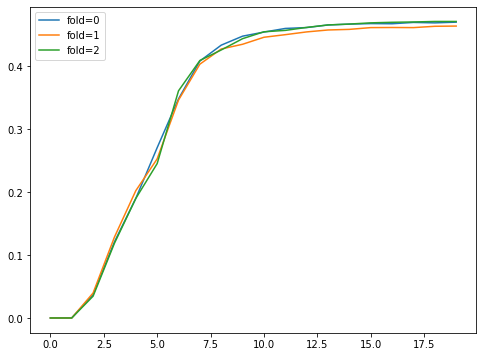

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for i in range(config.n_splits):
    history = pickle.load(open(str(base_dir / config.outdir / f'EfficientNetB3_seed{config.seed}_fold{i}' / 'history.pkl'), 'rb'))
    y = history['val_sparse_categorical_accuracy']
    ax.plot(y, label=f'fold={i}')
ax.legend()
plt.show()